<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Preparing the data

###Defining the control points

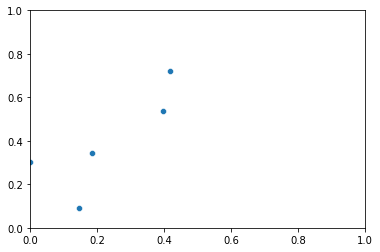

In [287]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1)
pointNum = 5
points = np.random.random((pointNum,2))
sns.scatterplot(x=points[:,0], y=points[:,1]).set(xlim=(0,1),ylim=(0,1));

###Defining training data generator

In [288]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  seed = 0
  def __init__(self, dataCount, batch_size, controlPoints):
    self.controlPoints = controlPoints
    self.dataCount = dataCount
    self.batch_size = batch_size
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return math.ceil(self.dataCount / self.batch_size)

  def dist(self, p):
    return np.linalg.norm(self.controlPoints-p, axis = 1).min()

  def __getitem__(self, idx):
    P = []
    d = []
    for i in range(self.batch_size):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    return np.array(P), np.array(d)

  def on_epoch_end(self):
    self.randGen = np.random.default_rng(seed=self.seed)
  
  def getAll(self):
    self.on_epoch_end()
    P = []
    d = []
    for i in range(self.batch_size * self.__len__()):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    self.on_epoch_end()
    return np.array(P), np.array(d)

###Creating generators

In [289]:
pointNum = 30000
validSplit = 0.1
testSplit  = 0.1
trainPointNum = int(pointNum*(1-validSplit-testSplit))
validPointNum = int(pointNum*validSplit)
testPointNum = int(pointNum*testSplit)

trainGen = DataGenerator(trainPointNum, 32, points)
validGen = DataGenerator(validPointNum, 32, points)
testGen = DataGenerator(testPointNum, 32, points)

##Creating model

In [290]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', kernel_initializer='he_normal', input_shape = (2,)),
    Dense(1, activation='linear')
])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [291]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam',
              loss = 'mse')
es = EarlyStopping(min_delta = 1e-6,
                        patience = 5,
                        verbose = 2,
                        restore_best_weights = True)

##Train

In [292]:
epochs = 50
history = model.fit(trainGen,
                    validation_data = validGen,
                    verbose = 1,
                    callbacks = [es],
                    epochs = epochs)

Epoch 1/50
750/750 [==============================] - 3s 3ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 2/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 9.6648e-04
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 9.5546e-04 - val_loss: 7.7146e-04
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 7.6336e-04 - val_loss: 5.3995e-04
Epoch 6/50
750/750 [==============================] - 2s 3ms/step - loss: 5.1040e-04 - val_loss: 3.7542e-04
Epoch 7/50
750/750 [==============================] - 2s 3ms/step - loss: 3.7175e-04 - val_loss: 3.1782e-04
Epoch 8/50
750/750 [==============================] - 2s 3ms/step - loss: 3.2029e-04 - val_loss: 2.8462e-04
Epoch 9/50
750/750 [==============================] - 2s 3ms/step - loss: 2.8957e-04 - val_loss: 2.6153e-04
Epoch 10/50
750/750 [===========================

##Evaluate

loss on test data: 0.00016112007142510265


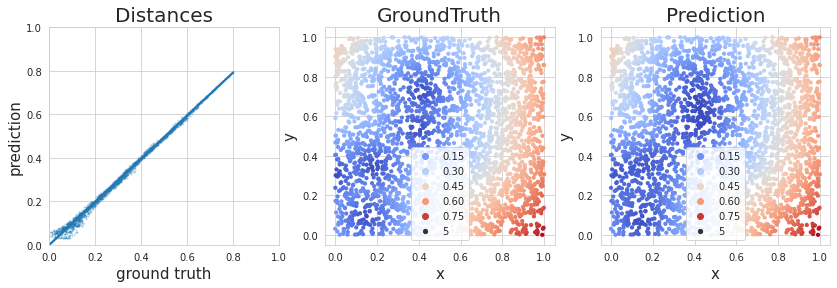

In [314]:
testX, testY = testGen.getAll()
print(f'loss on test data: {model.evaluate(testX, testY, verbose=0)}')
prediction = model.predict(testX)
plots = []
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols = 3,
                        figsize=(14,4))
plots.append(sns.regplot(x = testY, y = prediction, ax=axs[0], scatter_kws={'s':1, 'alpha':0.2}))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = testY, size = 5, linewidth = 0, palette='coolwarm', ax=axs[1]))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = prediction.reshape(-1), size = 5, linewidth = 0, palette='coolwarm', ax=axs[2]))
plots[0].set_title('Distances', fontsize = 20)
plots[0].set_ylabel('prediction', fontsize = 15)
plots[0].set(ylim=(0,1),xlim=(0,1))
plots[0].set_xlabel('ground truth', fontsize = 15)
plots[1].set_xlabel('x', fontsize = 15)
plots[1].set_ylabel('y', fontsize = 15)
plots[1].set_title('GroundTruth', fontsize = 20)
plots[2].set_xlabel('x', fontsize = 15)
plots[2].set_ylabel('y', fontsize = 15)
plots[2].set_title('Prediction', fontsize = 20);